# Fatima Fellowship Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. These coding challenges are not meant to take too long, do NOT spend more than 4-6 hours on them -- you can submit whatever you have.

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook along with your application. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw)



---


### **Important**: Beore you get started, please make sure to make a **copy of this notebook** and set sharing permissions so that **anyone with the link can view**. Otherwise, we will NOT be able to assess your application.



---



# 1. Deep Learning for Vision

**Generated by AI detector**: Train a model to detect if images are generated by AI

* Find a dataset of natural images and images generated by AI (here is one such dataset on the [Hugging Face Hub](https://huggingface.co/datasets/competitions/aiornot) but you're welcome to use any dataset you've found.
* Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify the image as being generated by an AI or not until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE
### I have chosen the dataset linked above for this task (competitions/aiornot)
### I have tried to fit a Neural Network Model as required.
### Below (After the Write Up) are the sections for each one of the above mentioned classifiers

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)
---

1. **Link to Hugging Face Hub:** https://huggingface.co/RishiDarkDevil/ai-image-det-resnet152

2. **Misclassified Images**:

  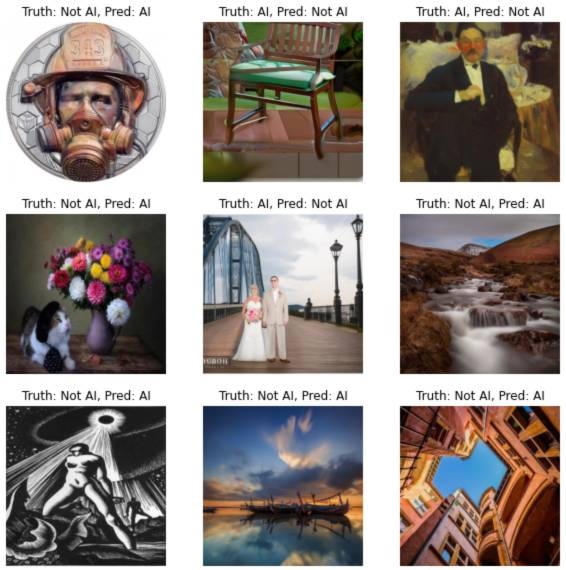

3. **How I can improve?** Here, I have tried out a basic approach of ResNet152 as feature extractor for the images and then adding Multi-Layer Perceptron Layers at the end for task specific training i.e. detecting AI generated images.

  I achieved accuracy of $92.50\%$ by the above approach.

  Some suggestions, by which I can improve the performance in future could be through:
  - Trying out other models as feature extractors e.g. CLIP. I have tried this idea (Accuracy: $95.20\%$) here: 
    - https://colab.research.google.com/drive/10n6V-jpoeXz9GmCmbFJj2xdM9i_IuNc9?usp=sharing
  - Trying out an ensemble approach of using multiple models to extract features and then concatenating/combining them to achieve better capture of information from the image. I have tried this idea (Accuracy: $95.70\%$) here: 
    - https://colab.research.google.com/drive/1OElLUM_ThXKQOTdJZag7g00Kowc8Pmcd?usp=sharing
  - Using Supervised Contrastive Learing Approach can help. I have tried that here, but due to lack of GPU hours on Colab couldn't complete the implementation: 
    - https://colab.research.google.com/drive/1jsLs6ggyQoIoqSqc7QeVM67g7K7ILcvo?usp=sharing
  - One interesting approach could be use Generative Models like Stable Diffusion to generate variations of Not AI images and learn features that make Non AI images different from AI images. 

## ResNet152 + MLP Classifier

#### Connecting Google Drive

In [ ]:
# Connecting Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive/MyDrive

Mounted at /content/gdrive/
/content/gdrive/MyDrive


#### Install Necessary Libraries

In [ ]:
# Install Libraries
%%capture
!pip install datasets
!pip install huggingface_hub
!pip install sklearn

#### Imports

In [ ]:
# Import Libraries

# General
import gc
import os
import random
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Matrix Manipulation
import numpy as np
import pandas as pd

# Image Handling
from torchvision.transforms import transforms
from torchvision import transforms, datasets

# Dataset
import huggingface_hub
from datasets import load_dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Model Building
import torch
from torch import nn
import torch.optim as optim

# Evaluation
import sklearn
from sklearn.metrics import confusion_matrix
# Random Seed
np.random.seed(0)

### Load and Process Data

In [ ]:
# # HuggingFace Login to access the data
huggingface_hub.notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Below I load and visualize the training data.

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-f559c639a48093b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


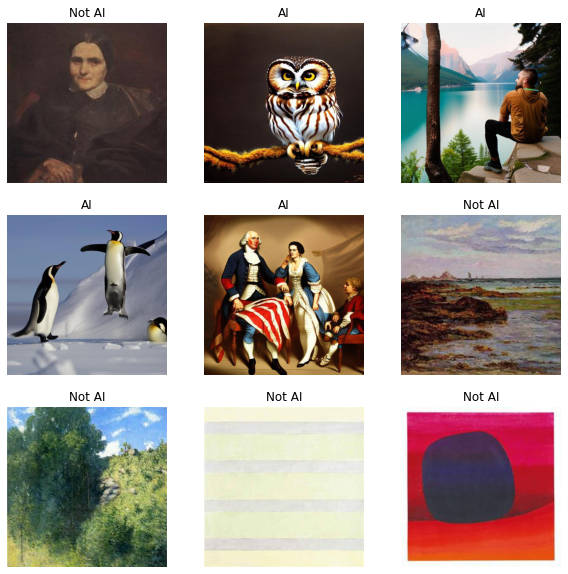

In [ ]:
# Load Train Data
dataset = load_dataset('competitions/aiornot', split='train')

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    _, img, label = dataset[sample_idx].values()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### ResNet152 Feature Extraction

I don't train the `ResNet152` Model because of the small size of the training data. I use it as a feature extractor for all the images which will be used later for fine-tuning to our task of detecting AI generated images.

In [ ]:
# DataLoader to load data
BATCH_SIZE = 512

# Preprocess Images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_fn(data):
  return torch.stack([preprocess(x['image']) for x in data]), torch.tensor([x['label'] for x in data])
  
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Loading ResNet152 Model to extract features from the images
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.fc = nn.Identity()
model.to('cuda')
model.eval()

# Extracting Features
image_features = list()
labels = list()

# Folder to save all extrated features
if not os.path.exists('Fatima-Fellowship-Challenge'):
  os.mkdir('Fatima-Fellowship-Challenge')
  os.mkdir('Fatima-Fellowship-Challenge/output')
  os.mkdir('Fatima-Fellowship-Challenge/label')


# Frees up GPU, when running inference in a loop, to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()

# Extracting Features
idx = 0
for batch, label in tqdm(dataloader):
  
  # Moving the batch image tensor to cuda
  batch = batch.to('cuda')
  
  # ResNet152 Feature Extraction
  with torch.no_grad():
    output = model(batch)
  
  # Saving Features
  torch.save(output, f'Fatima-Fellowship-Challenge/output/{idx}.pt')
  torch.save(label, f'Fatima-Fellowship-Challenge/label/{idx}.pt')
  idx += 1

  optimize_gpu()

# image_features = torch.concatenate(image_features)
# labels = torch.concatenate(labels)

### Dataset for Fine-Tuning

Since, I have already extracted the features using `ResNet152` model. I simply load the extracted features along with the labels to create the dataset for fine-tuning. This reduces the time of preprocessing or loading the images again and speeds up the process considerably.

In [ ]:
image_features = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/output/{i}.pt' for i in range(37)]]
image_labels = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/label/{i}.pt' for i in range(37)]]

In [ ]:
image_features = torch.concatenate(image_features)
image_labels = torch.concatenate(image_labels)

#### Train & Test Split

Since, I don't have labels for test data. I create train & validation split:
- Validation: 1000 images ($\sim 5\%$) of the total training dataset.
- Train: Remaining images of the total training dataset after selecting validation set.

This was done mainly to evaluate the performance of our model on validation dataset.

In [ ]:
# Creating train and validation datasets and their respective dataloaders
BATCH_SIZE = 32
VAL_SIZE = 1000
traindataset = TensorDataset(image_features[:-VAL_SIZE], image_labels[:-VAL_SIZE])
trainloader = DataLoader(traindataset, BATCH_SIZE, True)
valdataset = TensorDataset(image_features[-VAL_SIZE:], image_labels[-VAL_SIZE:])
valloader = DataLoader(valdataset, 1000)

#### Classifier

In [ ]:
classifier = nn.Sequential(
    nn.Linear(2048, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)

clasifier = classifier.cuda()

#### Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=0.9)

#### Training Classifier

In [ ]:
# Training Classifier till 150 Epochs
NUM_EPOCHS = 150
train_loss = list()
val_loss = list()

for epoch in range(NUM_EPOCHS):

  running_loss = 0.0
  for i, data in enumerate(trainloader):

    inputs, labels = data

    inputs = inputs.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()

    outputs = classifier(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      with torch.no_grad():
        inps, labs = next(iter(valloader))
        inps = inps.cuda()
        labs = labs.cuda()
        out = classifier(inps)
        val_los = criterion(out, labs).item()

      train_loss.append(running_loss)
      val_loss.append(val_los)

      print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss:.3f} | val_loss: {val_los:.3f}')
      running_loss = 0.0
            

print('Finished Training')

[1,   100] train_loss: 47.758 | val_loss: 0.359
[1,   200] train_loss: 33.059 | val_loss: 0.286
[1,   300] train_loss: 29.452 | val_loss: 0.263
[1,   400] train_loss: 27.024 | val_loss: 0.254
[1,   500] train_loss: 26.546 | val_loss: 0.246
[2,   100] train_loss: 25.260 | val_loss: 0.241
[2,   200] train_loss: 24.290 | val_loss: 0.242
[2,   300] train_loss: 24.880 | val_loss: 0.244
[2,   400] train_loss: 25.089 | val_loss: 0.230
[2,   500] train_loss: 23.135 | val_loss: 0.227
[3,   100] train_loss: 22.335 | val_loss: 0.227
[3,   200] train_loss: 23.870 | val_loss: 0.229
[3,   300] train_loss: 22.768 | val_loss: 0.221
[3,   400] train_loss: 22.264 | val_loss: 0.221
[3,   500] train_loss: 22.597 | val_loss: 0.224
[4,   100] train_loss: 21.119 | val_loss: 0.230
[4,   200] train_loss: 22.291 | val_loss: 0.225
[4,   300] train_loss: 21.362 | val_loss: 0.221
[4,   400] train_loss: 22.501 | val_loss: 0.217
[4,   500] train_loss: 21.920 | val_loss: 0.215
[5,   100] train_loss: 20.897 | val_loss

In [ ]:
# save model
if not os.path.exists('Fatima-Fellowship-Challenge/model'):
  os.mkdir('Fatima-Fellowship-Challenge/model')
torch.save(classifier.state_dict(), 'Fatima-Fellowship-Challenge/model/resnet152_mlp')

#### Training Dynamics

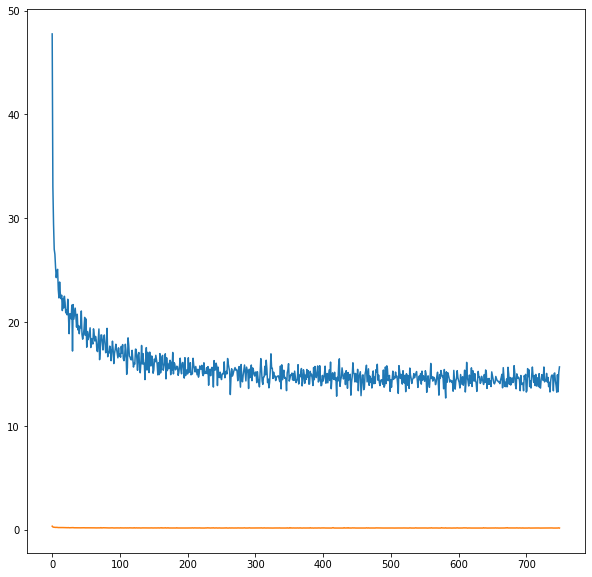

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)

### Inference & Evaluation

In [ ]:
# Evaluation of model performance on validation set
with torch.no_grad():
  pred_probs = classifier(next(iter(valloader))[0])

# The model's prediction
preds = np.argmax(pred_probs.cpu(), 1)

# Accuracy 
print('Accuracy:', torch.sum(preds == next(iter(valloader))[1].cpu()) / len(valdataset))

Accuracy: tensor(0.9250)


### Misclassified Images

Confusion Matrix for the model's performance is shown below.

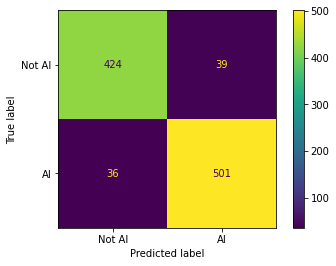

In [ ]:
# confusion matrix
cm = confusion_matrix(next(iter(valloader))[1].cpu(), preds)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Not AI', 'AI'])
cm_display.plot()
plt.show() 

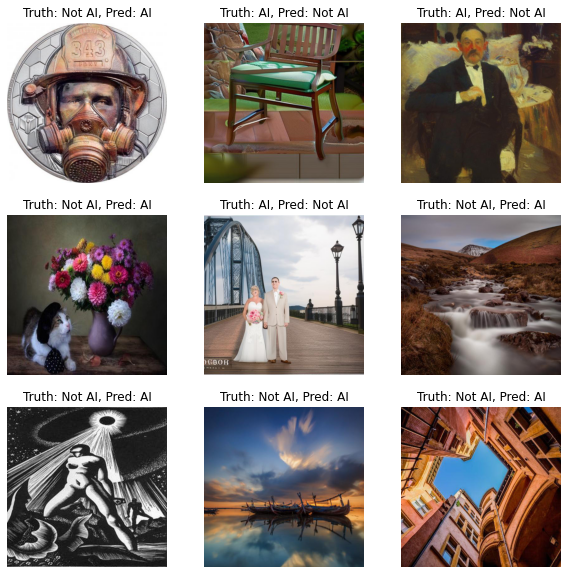

In [ ]:
# Misclassified Images
misclassified = list(((preds != next(iter(valloader))[1].cpu())).nonzero().squeeze().numpy())

# Validation Dataset
val_data = dataset[-VAL_SIZE:]

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = misclassified[random.randint(0, len(misclassified)-1)]
    img, label = val_data['image'][sample_idx], val_data['label'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Truth: {labels_map[label]}, Pred: {labels_map[list(preds.numpy())[sample_idx]]}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()